In [1]:
# read image


In [2]:
# read points from my points

# read points from tf

# read points from pretrained model

# print out one by one (nx3) images

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print (module_path)
%matplotlib inline

/home/saurabh.nair/giant_nerfs/pytorch-superpoint-new


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from imageio import imread
def load_as_float(path):
    return imread(path).astype(np.float32)/255

# folder = ['superpoint_pretrained_homoAdapt100_coco_small', 'magicpoint_synth14_200k_homoAdap100_coco_small', 
#           'magicpoint_synth20_homoAdapt100_coco']
# folder = ['superpoint_pretrained_homoAdapt100_coco_small', 'magicpoint_synth20_homoAdapt100_coco', 'magicpoint_coco20_homoAdapt_coco']
folder = ['superpoint_coco', 'magicpoint_synth20_homoAdapt100_coco']

# parameters
images_num = 20
task_folder = 'train'
rows = images_num
cols = len(folder)
scale = 12
plt.figure(figsize=(cols*scale, rows*scale))
# title = [f + ' | ' for f in folder]
# fig.suptitle('This is a somewhat long figure title', fontsize=16)
# plt.title('title')
count = 1
offset = 20

# get image names
base_path = '/scratch/aiscience/logs/superpoint/superpoint_coco/'
prediction = 'predictions'
file_path = Path(base_path, folder[0], prediction, task_folder)
# file_path = Path(base_path, folder[1], prediction, task_folder)
#         base_path = Path(DATA_PATH, 'COCO_small/' + task + '2014/')
image_paths = list(file_path.iterdir())
# print("image paths: ", image_paths)
names = [p.stem for p in image_paths]
# image_paths = [str(p) for p in image_paths if str(p)[-3:] == 'png']
# image_paths = [str(n + '.png') for n in names]
# print(image_paths[:10])
# show images
for i in range(images_num):
#     path = image_paths[i]
    for j in range(cols):
        exp_path = Path(base_path, folder[j], prediction, task_folder)
        path = exp_path / (names[offset + i] + '.png')
#         print("load from ", path)
        image = load_as_float(path)
        plt.subplot(rows, cols, count)
        count += 1
        plt.title(folder[j] + '/' + names[offset + i])
        plt.imshow(image)
plt.show()
#     print(i)



FileNotFoundError: [Errno 2] No such file or directory: '/scratch/aiscience/logs/superpoint/superpoint_coco/predictions/train'

<Figure size 1728x17280 with 0 Axes>

In [ ]:
import torch
def getLabels(points_path, img_shape):
    pnts = np.load(points_path)['pts']
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 1], pnts[:, 0]] = 1
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def pnts2img(pnts, img_shape):
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 0], pnts[:, 1]] = 1  # pnts (y,x)
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def filter_keypoints(points, shape):
    """ Keep only the points whose coordinates are
    inside the dimensions of shape. """
    """
    input: 
        points:
            numpy (N, (x,y))
        shape:
            (y, x)
    return:
        Points:
            numpy (N, (x,y))
    """
    mask = (points[:, 0] >= 0) & (points[:, 0] < shape[1]) &\
           (points[:, 1] >= 0) & (points[:, 1] < shape[0])
    return points[mask, :]

def warpLabels(pnts, homography, H, W):
    """
    input: 
        pnts: numpy
        homography: numpy
    output:
        warped_pnts: numpy
    """
    from utils.utils import warp_points
    from utils.utils import filter_points
    pnts = torch.tensor(pnts).long()
    homography = torch.tensor(homography, dtype=torch.float32)
    warped_pnts = warp_points(torch.stack((pnts[:, 0], pnts[:, 1]), dim=1),
                                   homography) # check the (x, y)
    warped_pnts = filter_points(warped_pnts, torch.tensor([W, H])).round().long()
    return warped_pnts.numpy()

def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])

    return img

def printImgPnts(image, pnts):
    img_shape = image.shape

    print(img_shape)
    labels_2D, pnts = pnts2img(pnts, img_shape)
    labels_2D = labels_2D.squeeze().numpy()
    print("labels ", labels_2D.shape)

    img_r = np.zeros_like(image)
    overlap = img_overlap(img_r[np.newaxis,:,:], 
                          labels_2D[np.newaxis,:,:], image[np.newaxis,:,:])
    print(overlap.shape)
    plt.imshow(overlap)
    plt.show()

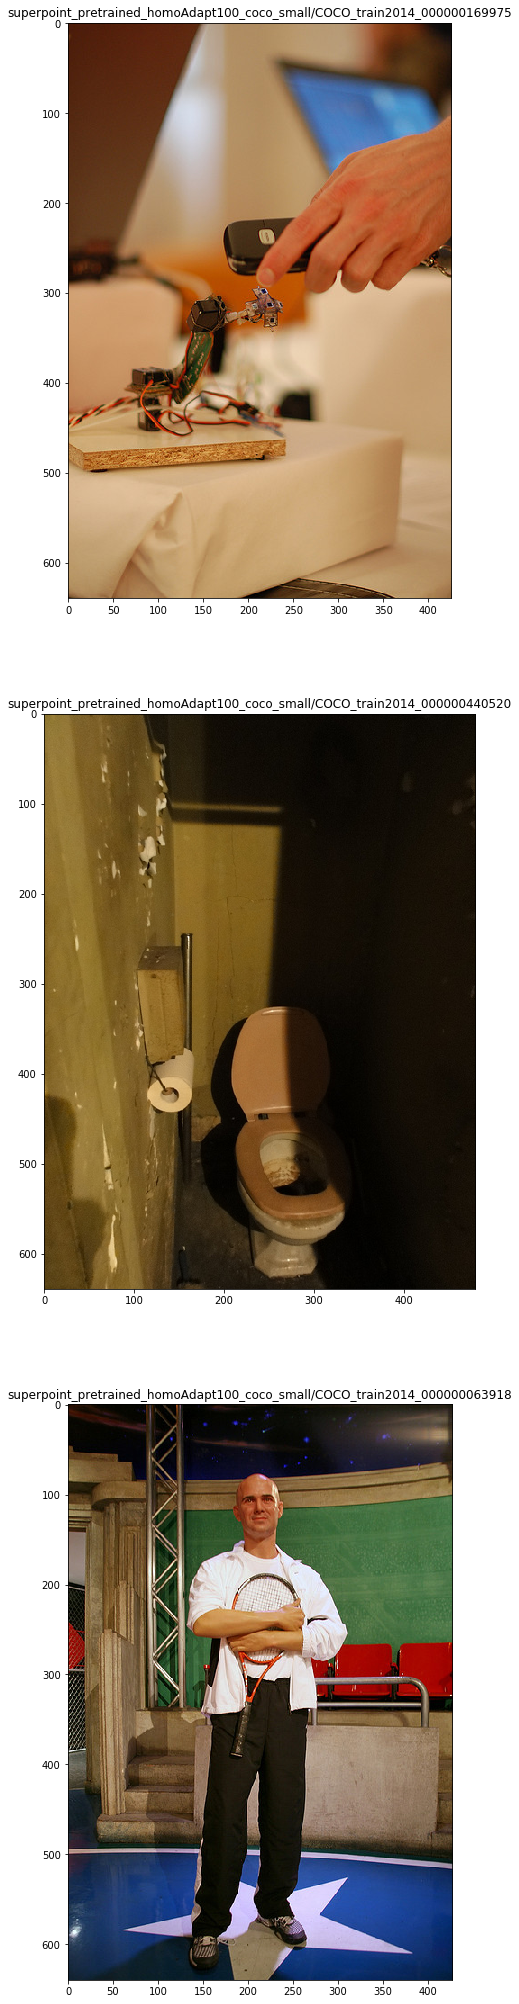

In [12]:
dataset_path = '../datasets/COCO/'

# parameters
images_num = 3
task_folder = 'train'
rows = images_num
cols = len(folder)
scale = 12
plt.figure(figsize=(cols*scale, rows*scale))
# title = [f + ' | ' for f in folder]
# fig.suptitle('This is a somewhat long figure title', fontsize=16)
# plt.title('title')
count = 1

# get image names
base_path = '../logs'
prediction = 'predictions'
file_path = Path(dataset_path, task_folder + '2014/')
# file_path = Path(base_path, folder[1], prediction, task_folder)
#         base_path = Path(DATA_PATH, 'COCO_small/' + task + '2014/')
image_paths = list(file_path.iterdir())
# print("image paths: ", image_paths)
names = [p.stem for p in image_paths]

for i in range(images_num):
#     path = image_paths[i]
    for j in range(cols):
        exp_path = Path(base_path, folder[j], prediction, task_folder)
#         path = exp_path / (names[i] + '.png')
        path = file_path / (names[i] + '.jpg')
#         print("load from ", path)
        image = load_as_float(path)
        plt.subplot(rows, cols, count)
        count += 1
        plt.title(folder[j] + '/' + names[i])
        plt.imshow(image)
plt.show()
#     print(i)

In [ ]:
names[:10]

In [ ]:
import os 
cwd = os.getcwd()
# dir_path = os.path.dirname(os.path.realpath(__file__))
print(cwd)